In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np

os.chdir('/content/drive/MyDrive/BRI Analysis')

In [22]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00


In [3]:
# @title Read back in data

clean_output_file = f'./data/cleaned_connective_chains.csv'
dirty_output_file = f'./data/dropout_chains.csv'

final_clean_df = pd.read_csv(clean_output_file)
final_dirty_df = pd.read_csv(dirty_output_file)

#replace nan values of final_clean_df['chain_id'] with string 'NA'
final_clean_df['chain_id'] = final_clean_df['chain_id'].fillna('NA')
final_clean_df['chain_id'] = final_clean_df['chain_id'].astype(str)

#replace nan values of final_dirty_df['chain_id'] with string 'NA'
final_dirty_df['chain_id'] = final_dirty_df['chain_id'].fillna('NA')
final_dirty_df['chain_id'] = final_dirty_df['chain_id'].astype(str)

In [4]:
# add in meta data
meta_data = pd.read_csv('./data/PDB727K_webscrape_meta_data.csv')

#strip brackets from Resolution
# 1. Strip the brackets
# '[2.55]'      -> '2.55'
clean_step_1 = meta_data['Resolution'].astype(str).str.strip('[]')

# 2. Split by comma and take the first element
clean_step_2 = clean_step_1.str.split(',').str[0]

# 3. Convert to numeric
# This will handle the string '2.0' turning into float 2.0
# It also turns empty strings '' into NaN
meta_data['resolution'] = pd.to_numeric(clean_step_2, errors='coerce')

# 4. Convert release_date to datetime
meta_data['release_date'] = pd.to_datetime(meta_data['release_date'])
meta_data['release_date'] = meta_data['release_date'].dt.tz_localize(None).dt.normalize()

meta_data.head(5)

,pdb_id,Method,Resolution,R-Value Free,R-Value Work,R-Value Observed,citation,doi,authors,deposition_date,release_date,resolution
0,1A53,X-RAY DIFFRACTION,[2.0],0.212,0.159,0.159,The catalytic mechanism of indole-3-glycerol p...,10.1016/S0022-2836(02)00378-9,"Hennig, M.; Darimont, B.D.; Jansonius, J.N.; K...",1998-02-19T00:00:00Z,1999-03-23,2.0
1,1A54,X-RAY DIFFRACTION,[1.6],0.208,0.177,NaN,Crystal structure of phosphate binding protein...,10.1021/bi980428z,"Hirshberg, M.; Henrick, K.; Haire, L.L.; Vasis...",1998-02-19T00:00:00Z,1998-10-14,1.6
2,1A55,X-RAY DIFFRACTION,[2.4],0.227,0.173,NaN,Crystal structure of phosphate binding protein...,10.1021/bi980428z,"Hirshberg, M.; Henrick, K.; Haire, L.L.; Vasis...",1998-02-19T00:00:00Z,1998-10-14,2.4
3,1A56,SOLUTION NMR,NaN,NaN,NaN,NaN,Primary sequence and solution conformation of ...,NaN,"Timkovich, R.; Bergmann, D.; Arciero, D.M.; Ho...",1998-02-20T00:00:00Z,1998-10-21,NaN
4,1A57,SOLUTION NMR,NaN,NaN,NaN,NaN,The three-dimensional structure of a helix-les...,NaN,"Steele, R.A.; Emmert, D.A.; Kao, J.; Hodsdon, ...",1998-02-20T00:00:00Z,1998-05-27,NaN


In [5]:
# left join meta_data to final_clean_df on pdb_id, keeping the relevant columns
final_clean_df = final_clean_df.merge(meta_data[['pdb_id','resolution','release_date']],on='pdb_id',how='left')

In [6]:
#keep only the model 1 version of chains for now for accurate comparison with what happens in OpenFold
final_clean_df = final_clean_df[final_clean_df['model_id']==1].copy()

In [7]:
# @title Bulk Map PDB (Label) Chains to Author Chains
import requests
import pandas as pd
import math
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# 1. Prepare Unique PDB List
# We only need to query each PDB once, even if you have multiple chains from it
unique_pdb_ids = final_clean_df['pdb_id'].unique().tolist()
print(f"Processing {len(unique_pdb_ids)} unique PDB entries for {len(final_clean_df)} chains...")

# 2. Define GraphQL Query
# We ask specifically for the 'asym_id' (Label) and 'auth_asym_id' (Author)
query = """
query($ids: [String!]!) {
  entries(entry_ids: $ids) {
    rcsb_id
    polymer_entities {
      polymer_entity_instances {
        rcsb_polymer_entity_instance_container_identifiers {
          asym_id
          auth_asym_id
        }
      }
    }
  }
}
"""

def fetch_mapping_batch(batch_ids):
    """Fetches chain mapping for a batch of PDB IDs."""
    url = "https://data.rcsb.org/graphql"
    try:
        response = requests.post(
            url,
            json={'query': query, 'variables': {'ids': batch_ids}},
            timeout=10
        )
        if response.status_code == 200:
            return response.json()
        return None
    except:
        return None

# 3. Execute in Parallel (Chunks of 50)
BATCH_SIZE = 50
chunks = [unique_pdb_ids[i:i + BATCH_SIZE] for i in range(0, len(unique_pdb_ids), BATCH_SIZE)]
label_to_auth_map = {} # Key: (pdb_id, label_id), Value: auth_id

print(f"Querying RCSB Data API in {len(chunks)} batches...")

with ThreadPoolExecutor(max_workers=10) as executor:
    # Submit all tasks
    future_to_chunk = {executor.submit(fetch_mapping_batch, chunk): chunk for chunk in chunks}

    for future in tqdm(as_completed(future_to_chunk), total=len(chunks), desc="Fetching Chain IDs"):
        data = future.result()
        if data and 'data' in data and 'entries' in data['data']:
            for entry in data['data']['entries']:
                pdb = entry['rcsb_id'].upper()

                # Navigate the nested JSON structure
                if 'polymer_entities' in entry:
                    for entity in entry['polymer_entities']:
                        if 'polymer_entity_instances' in entity:
                            for instance in entity['polymer_entity_instances']:
                                ids = instance.get('rcsb_polymer_entity_instance_container_identifiers', {})

                                label_id = ids.get('asym_id')
                                auth_id = ids.get('auth_asym_id')

                                if label_id and auth_id:
                                    # Store mapping
                                    label_to_auth_map[(pdb, label_id)] = auth_id

print(f"\nMapping retrieved for {len(label_to_auth_map)} chains.")

# 4. Apply Mapping to DataFrame
# We create a new column 'author_chain_id'
def get_auth_id(row):
    # Lookup key: (PDB_ID, CURRENT_CHAIN_ID)
    key = (str(row['pdb_id']).upper(), str(row['chain_id']))
    return label_to_auth_map.get(key, None) # Returns None if not found

print("Applying mapping to dataframe...")
final_clean_df['author_chain_id'] = final_clean_df.apply(get_auth_id, axis=1)

# 5. Check Results
mapped_count = final_clean_df['author_chain_id'].notna().sum()
print(f"Successfully mapped {mapped_count} out of {len(final_clean_df)} rows.")

# Inspect rows where mapping changed (Label != Author)
diff_df = final_clean_df[final_clean_df['chain_id'] != final_clean_df['author_chain_id']]
if len(diff_df) > 0:
    print(f"\n{len(diff_df)} chains have different Label vs Author IDs. Sample:")
    display(diff_df[['pdb_id', 'chain_id', 'author_chain_id']].head())
else:
    print("\nNote: For this dataset, all Author IDs matched the Label IDs (or mapping failed).")

Processing 110318 unique PDB entries for 478074 chains...
Querying RCSB Data API in 2207 batches...


Fetching Chain IDs:   0%|          | 0/2207 [00:00<?, ?it/s]


Mapping retrieved for 599241 chains.
Applying mapping to dataframe...
Successfully mapped 450439 out of 478074 rows.

235070 chains have different Label vs Author IDs. Sample:


,pdb_id,chain_id,author_chain_id
17,10MH,C,A
50,12E8,A,L
51,12E8,C,M
77,148L,B,S
92,15C8,A,L


In [8]:
final_clean_df.to_csv(f'./data/cleaned_connective_chains_auth_chain_id.csv',index=False)

In [9]:
final_clean_df = pd.read_csv(f'./data/cleaned_connective_chains_auth_chain_id.csv')

In [10]:
final_clean_df['release_date'] = pd.to_datetime(final_clean_df['release_date'])
final_clean_df['author_chain_id'] = final_clean_df['author_chain_id'].fillna('NA')

In [11]:
final_clean_df.head(5)

,pdb_id,model_id,chain_id,start_residue,chain_length,seq,resolution,release_date,author_chain_id
0,101M,1,A,1,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,2.07,1998-04-08,A
1,102L,1,A,1,163,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,1.74,1993-10-31,A
2,102M,1,A,1,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,1.84,1998-04-08,A
3,103M,1,A,1,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,2.07,1998-04-08,A
4,104L,1,A,1,164,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...,2.80,1993-10-31,A


=== 1. Downloading OpenFold Data (using boto3) ===
  [INFO] Found local file: openfold_duplicate_chains.txt
  [INFO] Found local file: openfold_chain_data_cache.json

=== 2. Processing Chains ===
  -> Identified 472,464 duplicate chains to exclude.
  -> Loading JSON cache (this takes a moment)...
  -> OpenFold Unique Pool (Raw): 128,793 chains

[INFO] Applying strict OpenFold training restrictions...

--- Filtering OPENFOLD ---
  -> Dropped 17,666 chains (Date/Res/Len filters).
  -> FINAL OPENFOLD SET: 111,127 chains

--- Filtering USER ---
  -> Dropped 193,610 chains (Date/Res/Len filters).
  -> FINAL USER SET: 284,464 chains

=== 3. Overlap Results ===
Intersection (Match):             44,439
User Unique (Not in OpenFold):    227,416
OpenFold Unique (Not in User):    66,688


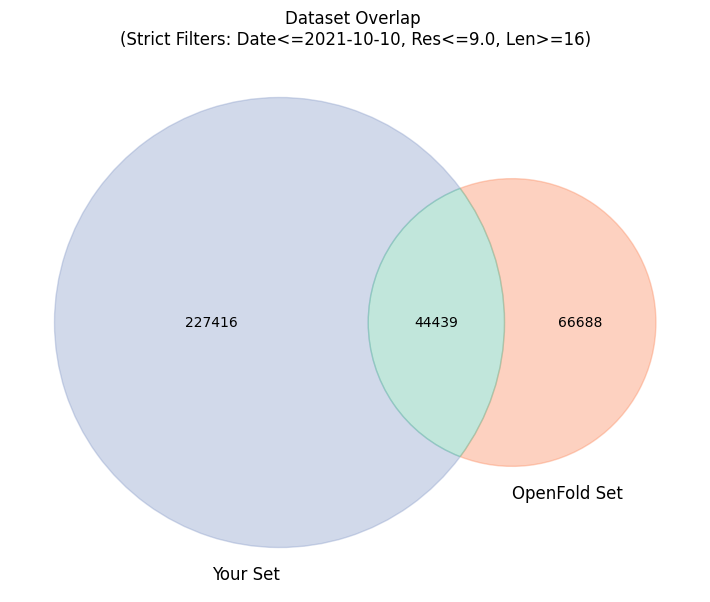


Sample of chains in Your Set but NOT in OpenFold (Ghost Chains?):


,pdb_id,chain_id,author_chain_id,release_date
0,101M,A,A,1998-04-08
2,102M,A,A,1998-04-08
3,103M,A,A,1998-04-08
5,104L,B,B,1993-10-31
6,104M,A,A,1998-04-08


In [25]:
# @title Complete OpenFold Comparison (Boto3 / Python Method)
import pandas as pd
import json
import os
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# --- Configuration ---
APPLY_FILTERS = True
CUTOFF_DATE = "2021-10-10"
MAX_RESOLUTION = 9.0
MIN_LENGTH = 16

# --- File Paths ---
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

CACHE_FILE = os.path.join(DATA_DIR, 'openfold_chain_data_cache.json')
DUPLICATES_FILE = os.path.join(DATA_DIR, 'openfold_duplicate_chains.txt')

# --- 1. Robust Download Function (using boto3) ---
print("=== 1. Downloading OpenFold Data (using boto3) ===")

def download_openfold_s3(key, local_path):
    """
    Downloads a file from the public 'openfold' S3 bucket using anonymous credentials.
    """
    # Check if file exists and is valid
    if os.path.exists(local_path) and os.path.getsize(local_path) > 1000:
        print(f"  [INFO] Found local file: {os.path.basename(local_path)}")
        return True

    print(f"  [DOWNLOADING] s3://openfold/{key} ...")

    # Configure anonymous S3 client (no sign-in required)
    s3 = boto3.client('s3', region_name='us-east-1', config=Config(signature_version=UNSIGNED))

    try:
        s3.download_file(Bucket='openfold', Key=key, Filename=local_path)
        print("  -> Success.")
        return True
    except Exception as e:
        print(f"  [ERROR] Failed to download {key}: {e}")
        return False

# 1.1 Download Files
# Note: We try two common locations for the duplicates file just in case
if not download_openfold_s3('duplicate_pdb_chains.txt', DUPLICATES_FILE):
    print("  -> Retrying duplicates file at alternate path...")
    if not download_openfold_s3('pdb_data/duplicate_pdb_chains.txt', DUPLICATES_FILE):
        raise RuntimeError("Could not find duplicates file in S3 bucket.")

# Download the main chain cache
if not download_openfold_s3('pdb_data/data_caches/chain_data_cache.json', CACHE_FILE):
    raise RuntimeError("Could not download chain cache.")

# --- 2. Processing Data ---
print("\n=== 2. Processing Chains ===")

# 2.1 Load Duplicates (Blocklist)
duplicate_chains = set()
try:
    with open(DUPLICATES_FILE, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # Format: Representative Chain1 Chain2 ...
            # We want to exclude Chain1, Chain2, etc.
            if len(parts) > 1:
                for dup in parts[1:]:
                    duplicate_chains.add(dup.upper())
    print(f"  -> Identified {len(duplicate_chains):,} duplicate chains to exclude.")
except Exception as e:
    raise ValueError(f"Error reading duplicates file: {e}")

# 2.2 Load JSON Cache
print("  -> Loading JSON cache (this takes a moment)...")
with open(CACHE_FILE, 'r') as f:
    raw_data = json.load(f)

# 2.3 Convert to DataFrame (Filtering out duplicates)
of_rows = []
for key, meta in raw_data.items():
    # Key is typically PDB_CHAIN (e.g. 1A53_A)
    # 1. Deduplication Filter
    if key.upper() in duplicate_chains:
        continue

    # 2. Basic Validity Check
    parts = key.split('_')
    if len(parts) < 2: continue

    of_rows.append({
        'pdb_id': parts[0].upper().strip(),
        'chain_id': parts[1].strip(),
        'release_date': meta.get('release_date', '1900-01-01'),
        'resolution': meta.get('resolution', 99.0),
        'chain_length': len(meta.get('seq', ''))
    })

df_openfold = pd.DataFrame(of_rows)
df_openfold['release_date'] = pd.to_datetime(df_openfold['release_date'], errors='coerce')

print(f"  -> OpenFold Unique Pool (Raw): {len(df_openfold):,} chains")
# (Target is approx 132k - 140k)

# --- 3. Preparing User Data ---
# Ensure your local data (final_clean_df) is clean
if 'author_chain_id' not in final_clean_df.columns:
    raise ValueError("Column 'author_chain_id' missing in your dataframe (final_clean_df).")

final_clean_df['pdb_id'] = final_clean_df['pdb_id'].astype(str).str.upper().str.strip()
final_clean_df['author_chain_id'] = final_clean_df['author_chain_id'].astype(str).str.strip()

# --- 4. Comparison Logic ---
def apply_openfold_filters(df, name):
    print(f"\n--- Filtering {name} ---")
    start_len = len(df)

    # Date Fix
    if df['release_date'].dt.tz is not None:
        df['release_date'] = df['release_date'].dt.tz_localize(None)

    # Apply Strict Rules
    pass_date = df[df['release_date'] <= pd.to_datetime(CUTOFF_DATE)]
    pass_res = pass_date[(pass_date['resolution'] <= MAX_RESOLUTION) & (pass_date['resolution'] > 0)]
    final = pass_res[pass_res['chain_length'] >= MIN_LENGTH]

    dropped = start_len - len(final)
    print(f"  -> Dropped {dropped:,} chains (Date/Res/Len filters).")
    print(f"  -> FINAL {name} SET: {len(final):,} chains")
    return final

if APPLY_FILTERS:
    print("\n[INFO] Applying strict OpenFold training restrictions...")
    df_of_compare = apply_openfold_filters(df_openfold, "OPENFOLD")
    df_user_compare = apply_openfold_filters(final_clean_df, "USER")
    title_suffix = f"\n(Strict Filters: Date<={CUTOFF_DATE}, Res<={MAX_RESOLUTION}, Len>={MIN_LENGTH})"
else:
    print("\n[INFO] Skipping filters. Using FULL unique datasets...")
    df_of_compare = df_openfold
    df_user_compare = final_clean_df
    title_suffix = "\n(Unrestricted Unique Chains)"

# --- 5. Visualization ---
print("\n=== 3. Overlap Results ===")

set_openfold = set(zip(df_of_compare['pdb_id'], df_of_compare['chain_id']))
set_user = set(zip(df_user_compare['pdb_id'], df_user_compare['author_chain_id']))

intersection = set_user.intersection(set_openfold)
user_unique = set_user - set_openfold
of_unique = set_openfold - set_user

print(f"Intersection (Match):             {len(intersection):,}")
print(f"User Unique (Not in OpenFold):    {len(user_unique):,}")
print(f"OpenFold Unique (Not in User):    {len(of_unique):,}")

plt.figure(figsize=(10, 7))
v = venn2(subsets=(len(user_unique), len(of_unique), len(intersection)),
          set_labels=('Your Set', 'OpenFold Set'))
try:
    if v.get_patch_by_id('10'): v.get_patch_by_id('10').set_color('#8da0cb')
    if v.get_patch_by_id('01'): v.get_patch_by_id('01').set_color('#fc8d62')
    if v.get_patch_by_id('11'): v.get_patch_by_id('11').set_color('#66c2a5')
except: pass

plt.title(f"Dataset Overlap {title_suffix}")
plt.show()

# List samples if Unrestricted User Unique exist
if len(user_unique) > 0:
    print("\nSample of chains in Your Set but NOT in OpenFold (Ghost Chains?):")
    # Identify rows
    def is_unique(row):
        return (str(row['pdb_id']), str(row['author_chain_id'])) in user_unique

    ghosts = df_user_compare[df_user_compare.apply(is_unique, axis=1)]
    cols = ['pdb_id', 'chain_id', 'author_chain_id', 'release_date']
    display(ghosts[[c for c in cols if c in ghosts.columns]].head())


# Also create a merged dataframe where df_of_compare and df_of_user are inner joined based on pdb_id and chain_id
intersection_df = df_user_compare.merge(df_of_compare, left_on=['pdb_id','author_chain_id'], right_on = ['pdb_id', 'chain_id'], how='inner')

In [ ]:
# What percentage of chain_lengths agree between the two data sources?
intersection_df['chain_length_agree'] = intersection_df['chain_length_x'] == intersection_df['chain_length_y']
intersection_df['chain_id'] = intersection_df['chain_id_x']
intersection_df['chain_id'] = intersection_df['chain_id'].fillna('NA')
print(intersection_df['chain_length_agree'].value_counts(normalize=True))
print(intersection_df['chain_length_agree'].sum())

chain_length_agree
False    0.702175
True     0.297825
Name: proportion, dtype: float64
82766


In [ ]:
# @title Search for near duplicates amongst overlapping chains (caveat: chain lengths might not necessarily match)

mean_invariants = pd.read_csv("./data/PDB727K_mean_invariants_with_batch.csv")
mean_invariants = mean_invariants[mean_invariants['model_id']==1].copy()
mean_invariants['chain_id'] = mean_invariants['chain_id'].fillna('NA')
print(len(mean_invariants))

477859


In [ ]:
mean_invariants_intersection = mean_invariants.merge(intersection_df[['pdb_id','chain_id','author_chain_id']],on=['pdb_id','chain_id'],how='inner')
print(len(mean_invariants_intersection))

277898


In [ ]:
# Find near duplicates from this data frame



Found 3 missing rows.
       pdb_id chain_id author_chain_id
111390   4P6Q        A               A
129326   4YLD        B               B
175993   5ZKM        A               A


In [ ]:
# @title Generate Small Training & Validation Sets (1000 chains)
import pandas as pd
import numpy as np
import os

# --- Configuration ---
TARGET_SIZE = 1000
VAL_SPLIT = 0.05  # 5% for validation (50 chains)
OUTPUT_DIR = './data/subset_training'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Identify the Overlap Candidates (From previous step)
# We assume 'df_user_compare' and 'df_of_compare' exist from the previous Venn code
# We need the INTERSECTION: chains in BOTH your set and OpenFold
# (Because we need the MSAs to exist in the OpenFold database)

print("Identifying overlap candidates...")
# Re-calculate intersection if variables are gone
intersection_keys = set(zip(df_user_compare['pdb_id'], df_user_compare['author_chain_id'])).intersection(
    set(zip(df_of_compare['pdb_id'], df_of_compare['chain_id']))
)

# Convert back to DataFrame
overlap_df = df_user_compare[
    df_user_compare.apply(lambda x: (x['pdb_id'], x['author_chain_id']) in intersection_keys, axis=1)
].copy()

print(f"Total Overlap Pool: {len(overlap_df)} chains")

# 2. Sample 1000 Random Chains
if len(overlap_df) > TARGET_SIZE:
    subset_df = overlap_df.sample(n=TARGET_SIZE, random_state=42) # Fixed seed for reproducibility
else:
    print(f"Warning: Only {len(overlap_df)} chains available. Using all of them.")
    subset_df = overlap_df.copy()

# 3. Split into Train/Validation
# Shuffle first
subset_df = subset_df.sample(frac=1, random_state=42).reset_index(drop=True)

val_size = int(len(subset_df) * VAL_SPLIT)
train_df = subset_df.iloc[:-val_size]
val_df = subset_df.iloc[-val_size:]

print(f"Training Set:   {len(train_df)} chains")
print(f"Validation Set: {len(val_df)} chains")

# 4. Format for OpenFold
# OpenFold expects specific columns in the CSV.
# Standard columns: 'pdb_name', 'release_date', 'resolution', 'chain_length', 'seq'
# Note: 'pdb_name' usually combines PDB + Chain (e.g., '1abc_A')

def format_for_openfold(df):
    out = pd.DataFrame()
    # Format: 1abc_A (Using Author Chain ID)
    out['name'] = df['pdb_id'].str.lower() + '_' + df['author_chain_id']
    out['release_date'] = df['release_date'].dt.strftime('%Y-%m-%d')
    out['resolution'] = df['resolution']
    out['seq'] = df['seq'] # Ensure you have the sequence column!
    # Additional useful metadata
    out['length'] = df['chain_length']
    return out

train_csv = format_for_openfold(train_df)
val_csv = format_for_openfold(val_df)

# 5. Save Files
train_path = os.path.join(OUTPUT_DIR, 'training_subset.csv')
val_path = os.path.join(OUTPUT_DIR, 'validation_subset.csv')

train_csv.to_csv(train_path, index=False)
val_csv.to_csv(val_path, index=False)

print(f"\nFiles saved to {OUTPUT_DIR}")
print(f" - {train_path}")
print(f" - {val_path}")

# Display sample
print("\nSample Training Entry:")
display(train_csv.head(1))

Identifying overlap candidates...
Total Overlap Pool: 271253 chains
Training Set:   950 chains
Validation Set: 50 chains

Files saved to ./data/subset_training
 - ./data/subset_training/training_subset.csv
 - ./data/subset_training/validation_subset.csv

Sample Training Entry:


,name,release_date,resolution,seq,length
0,6p5n_Ag,2019-09-25,3.2,VQRLTYRRRLSYNTASNKTRLSRTPGNRIVYLYTKKVGKAPKSACG...,114


In [ ]:
import json
import os
import requests
import pandas as pd

# 1. Configuration: Path to the OpenFold S3 Cache
OPENFOLD_CACHE_URL = "https://openfold.s3.amazonaws.com/data_caches/chain_data_cache.json"
LOCAL_CACHE_PATH = "chain_data_cache.json"

def get_openfold_metadata(cache_path):
    # Download the cache file if it doesn't exist locally
    if not os.path.exists(cache_path):
        print(f"Downloading OpenFold cache from {OPENFOLD_CACHE_URL}...")
        response = requests.get(OPENFOLD_CACHE_URL)
        with open(cache_path, 'wb') as f:
            f.write(response.content)

    # Load the JSON data
    print("Loading and parsing cache...")
    with open(cache_path, 'r') as f:
        data = json.load(f)

    # 2. Extract specific fields for each chain
    # OpenFold cache keys are usually format: {pdb_id}_{chain_id}
    rows = []
    for chain_key, metadata in data.items():
        # Split PDB and Chain ID
        parts = chain_key.split('_')
        pdb_id = parts[0]
        chain_id = parts[1] if len(parts) > 1 else "A"

        rows.append({
            'pdb_id': pdb_id.upper(),
            'chain_id': chain_id,
            'chain_length': len(metadata.get('seq', '')), # Length derived from the sequence
            'release_date': metadata.get('release_date', None), # Deposition/Release date
            'resolution': metadata.get('resolution', None)     # Resolution in Angstroms
        })

    # 3. Convert to DataFrame
    df = pd.DataFrame(rows)

    # Format dates for easier filtering
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    return df

# Execute and display results
metadata_df = get_openfold_metadata(LOCAL_CACHE_PATH)
print(f"Successfully processed {len(metadata_df):,} chains.")
print(metadata_df.head())

Loading and parsing cache...
Successfully processed 634,434 chains.
  pdb_id chain_id  chain_length release_date  resolution
0   6KL0        A           228   2019-12-11       0.798
1   3C7U        A           263   2008-10-07       2.200
2   3C7U        C           263   2008-10-07       2.200
3   3C7U        B           165   2008-10-07       2.200
4   3C7U        D           165   2008-10-07       2.200


In [ ]:
metadata_df[metadata_df['chain_length']==2]

,pdb_id,chain_id,chain_length,release_date,resolution
14375,7PJV,y,2,2021-10-20,3.10
27172,7ACJ,W,2,2021-08-18,3.20
44483,6GB5,G,2,2019-03-06,2.30
44484,6GB5,H,2,2019-03-06,2.30
88257,7PJZ,y,2,2021-10-20,6.00
122259,7AC6,Y,2,2021-09-01,3.00
155299,7PJU,y,2,2021-11-17,9.50
171598,7ACR,W,2,2021-08-18,3.44
196793,7PMY,B,2,2021-10-20,3.80
227692,7PJY,y,2,2021-10-20,3.10
